In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries imported successfully!")
print(f"Prophet version: {Prophet.__version__ if hasattr(Prophet, '__version__') else 'installed'}")

Libraries imported successfully!
Prophet version: installed


In [3]:
# Load the processed data
df = pd.read_csv('../data/superstore.csv', encoding='latin-1')

# Convert date column
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Aggregate sales by day
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales.columns = ['ds', 'y']  # Prophet requires these column names

print(f"Data shape: {daily_sales.shape}")
print(f"Date range: {daily_sales['ds'].min()} to {daily_sales['ds'].max()}")
print(f"\nFirst few rows:")
daily_sales.head()

Data shape: (1237, 2)
Date range: 2014-01-03 00:00:00 to 2017-12-30 00:00:00

First few rows:


,ds,y
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,4407.100
4,2014-01-07,87.158


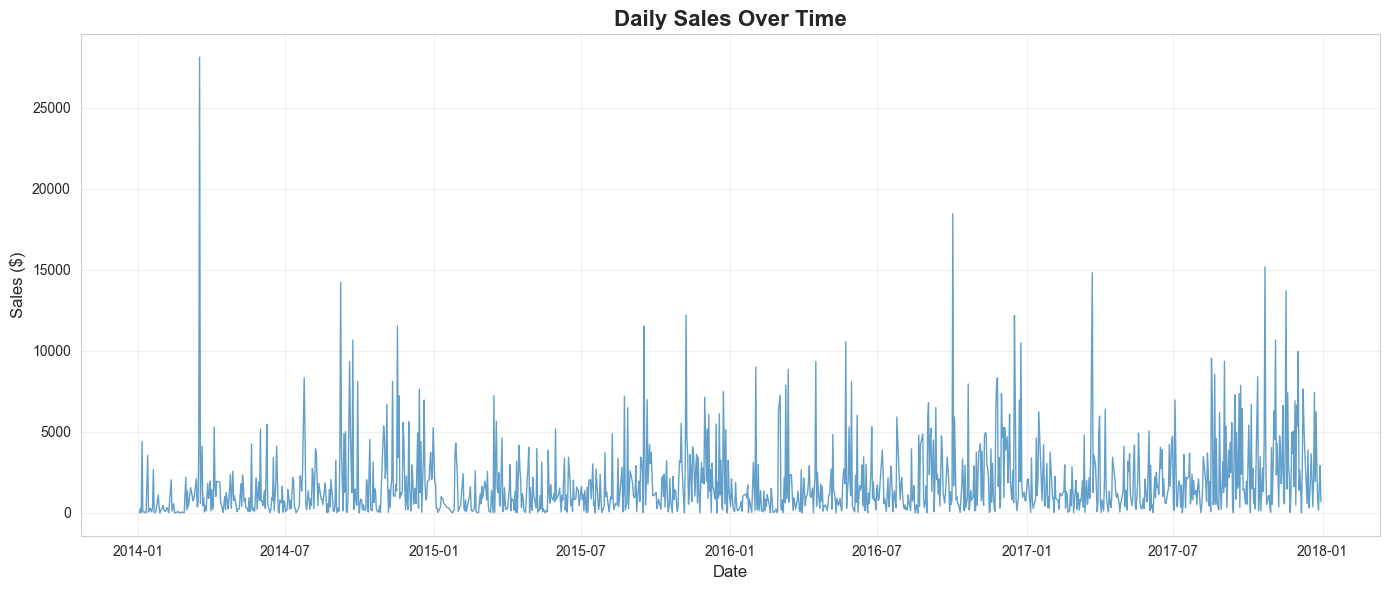

Total Sales: $2,297,200.86
Average Daily Sales: $1,857.07
Max Daily Sales: $28,106.72


In [4]:
# Plot the time series
plt.figure(figsize=(14, 6))
plt.plot(daily_sales['ds'], daily_sales['y'], alpha=0.7, linewidth=1)
plt.title('Daily Sales Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total Sales: ${daily_sales['y'].sum():,.2f}")
print(f"Average Daily Sales: ${daily_sales['y'].mean():,.2f}")
print(f"Max Daily Sales: ${daily_sales['y'].max():,.2f}")

In [5]:
# Split data - use last 3 months as test set
split_date = '2017-10-01'
train = daily_sales[daily_sales['ds'] < split_date].copy()
test = daily_sales[daily_sales['ds'] >= split_date].copy()

print(f"Training data: {len(train)} days ({train['ds'].min()} to {train['ds'].max()})")
print(f"Test data: {len(test)} days ({test['ds'].min()} to {test['ds'].max()})")
print(f"\nTrain sales: ${train['y'].sum():,.2f}")
print(f"Test sales: ${test['y'].sum():,.2f}")

Training data: 1150 days (2014-01-03 00:00:00 to 2017-09-30 00:00:00)
Test data: 87 days (2017-10-01 00:00:00 to 2017-12-30 00:00:00)

Train sales: $2,017,146.79
Test sales: $280,054.07


In [21]:
# Initialize and train the model
print("Training Prophet model...")
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',  # Better for data with growing trends
    changepoint_prior_scale=0.05  # Flexibility for trend changes
)

# Fit the model
model.fit(train)
print("Model trained successfully!")

13:49:51 - cmdstanpy - INFO - Chain [1] start processing
13:49:51 - cmdstanpy - INFO - Chain [1] done processing


Training Prophet model...
Model trained successfully!


In [7]:
# Create future dataframe for test period
future_test = model.make_future_dataframe(periods=len(test), freq='D')

# Predict
forecast_test = model.predict(future_test)

# Get predictions for test period only
test_predictions = forecast_test[forecast_test['ds'] >= split_date].copy()

# Calculate error metrics
mae = mean_absolute_error(test['y'], test_predictions['yhat'])
rmse = np.sqrt(mean_squared_error(test['y'], test_predictions['yhat']))
mape = np.mean(np.abs((test['y'] - test_predictions['yhat']) / test['y'])) * 100

print("=" * 60)
print("MODEL PERFORMANCE ON TEST SET")
print("=" * 60)
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print("=" * 60)

# Compare actual vs predicted totals
print(f"\nActual total sales (Oct-Dec 2017): ${test['y'].sum():,.2f}")
print(f"Predicted total sales (Oct-Dec 2017): ${test_predictions['yhat'].sum():,.2f}")
print(f"Difference: ${(test_predictions['yhat'].sum() - test['y'].sum()):,.2f}")

MODEL PERFORMANCE ON TEST SET
Mean Absolute Error (MAE): $2,286.94
Root Mean Squared Error (RMSE): $3,154.30
Mean Absolute Percentage Error (MAPE): 769.54%

Actual total sales (Oct-Dec 2017): $280,054.07
Predicted total sales (Oct-Dec 2017): $245,898.68
Difference: $-34,155.39


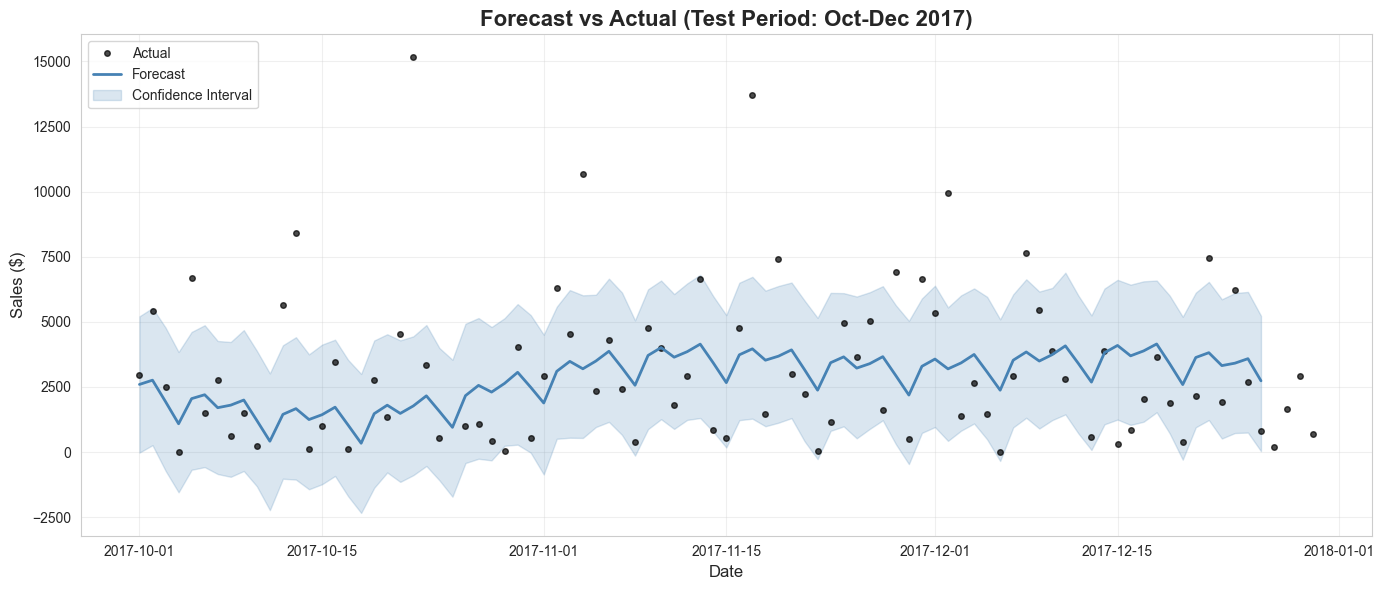

In [8]:
# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(14, 6))

# Plot actual test data
ax.plot(test['ds'], test['y'], 'o', color='black', label='Actual', markersize=4, alpha=0.7)

# Plot predictions
ax.plot(test_predictions['ds'], test_predictions['yhat'], color='steelblue', 
        linewidth=2, label='Forecast')

# Plot confidence interval
ax.fill_between(test_predictions['ds'], 
                test_predictions['yhat_lower'], 
                test_predictions['yhat_upper'],
                color='steelblue', alpha=0.2, label='Confidence Interval')

ax.set_title('Forecast vs Actual (Test Period: Oct-Dec 2017)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Sales ($)', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
# Retrain model on ALL available data (including test set)
print("Retraining model on complete dataset...")
model_full = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05
)

model_full.fit(daily_sales)
print("Model retrained on full dataset!")

13:49:43 - cmdstanpy - INFO - Chain [1] start processing


Retraining model on complete dataset...


13:49:44 - cmdstanpy - INFO - Chain [1] done processing


Model retrained on full dataset!


In [10]:
# Create future dataframe for next 365 days (12 months)
future = model_full.make_future_dataframe(periods=365, freq='D')

# Generate forecast
forecast = model_full.predict(future)

# Extract only the future predictions (2018)
future_forecast = forecast[forecast['ds'] > daily_sales['ds'].max()].copy()

print(f"Forecast period: {future_forecast['ds'].min()} to {future_forecast['ds'].max()}")
print(f"Number of days forecasted: {len(future_forecast)}")
print(f"\nPredicted total sales for 2018: ${future_forecast['yhat'].sum():,.2f}")
print(f"Average daily sales forecast: ${future_forecast['yhat'].mean():,.2f}")

Forecast period: 2017-12-31 00:00:00 to 2018-12-30 00:00:00
Number of days forecasted: 365

Predicted total sales for 2018: $869,327.54
Average daily sales forecast: $2,381.72


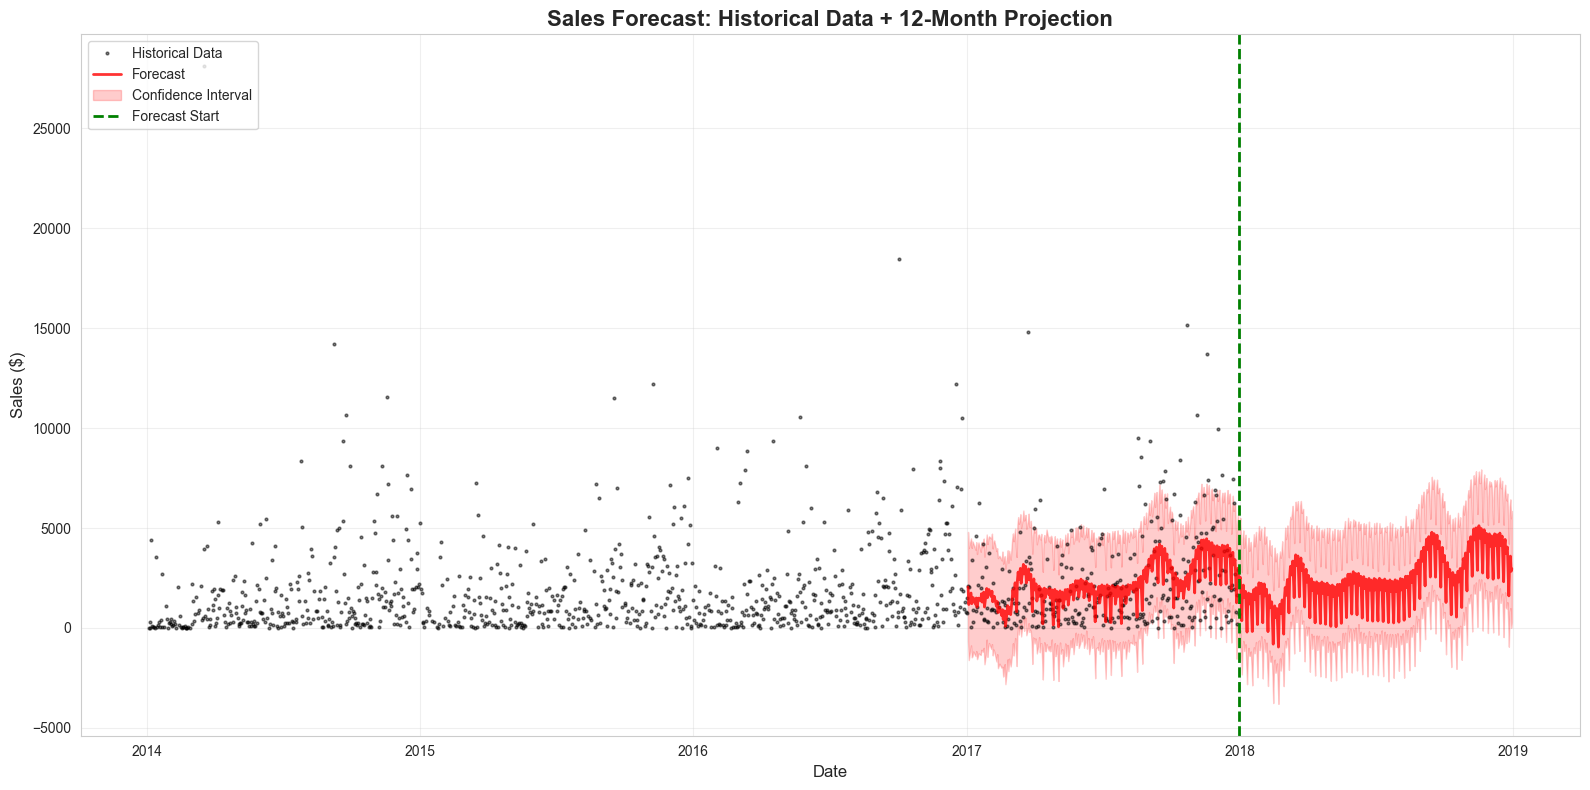

In [11]:
# Plot historical + forecast
fig, ax = plt.subplots(figsize=(16, 8))

# Plot historical data
ax.plot(daily_sales['ds'], daily_sales['y'], 'o', 
        color='black', label='Historical Data', markersize=2, alpha=0.5)

# Plot forecast
forecast_line = forecast[forecast['ds'] > '2017-01-01']
ax.plot(forecast_line['ds'], forecast_line['yhat'], 
        color='red', linewidth=2, label='Forecast', alpha=0.8)

# Confidence interval
ax.fill_between(forecast_line['ds'], 
                forecast_line['yhat_lower'], 
                forecast_line['yhat_upper'],
                color='red', alpha=0.2, label='Confidence Interval')

# Add vertical line at forecast start
ax.axvline(x=daily_sales['ds'].max(), color='green', 
          linestyle='--', linewidth=2, label='Forecast Start')

ax.set_title('Sales Forecast: Historical Data + 12-Month Projection', 
            fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Sales ($)', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# Aggregate daily forecast to monthly for cleaner visualization
forecast['year_month'] = forecast['ds'].dt.to_period('M')
monthly_forecast = forecast.groupby('year_month').agg({
    'yhat': 'sum',
    'yhat_lower': 'sum',
    'yhat_upper': 'sum'
}).reset_index()

monthly_forecast['year_month'] = monthly_forecast['year_month'].dt.to_timestamp()

# Get only 2018 forecast
monthly_2018 = monthly_forecast[monthly_forecast['year_month'] >= '2018-01-01'].copy()

# Also aggregate historical data by month
daily_sales['year_month'] = daily_sales['ds'].dt.to_period('M')
monthly_historical = daily_sales.groupby('year_month').agg({
    'y': 'sum'
}).reset_index()
monthly_historical['year_month'] = monthly_historical['year_month'].dt.to_timestamp()

print("Monthly Forecast for 2018:")
print(monthly_2018[['year_month', 'yhat', 'yhat_lower', 'yhat_upper']].head(12))

Monthly Forecast for 2018:
   year_month           yhat    yhat_lower     yhat_upper
48 2018-01-01   43781.721245 -40949.982099  128728.364431
49 2018-02-01   24740.474358 -52377.264134  101549.282938
50 2018-03-01   78781.448842  -5729.121629  163796.801920
51 2018-04-01   52764.388102 -28538.517972  135217.916109
52 2018-05-01   53088.452568 -32246.696079  137225.495833
53 2018-06-01   59394.562791 -23280.891814  140988.111392
54 2018-07-01   55917.423402 -27734.275378  140330.115652
55 2018-08-01   69143.285649 -15448.096688  152961.545839
56 2018-09-01  113754.480920  30243.540301  195775.989565
57 2018-10-01   76450.111389  -8068.596815  160055.228586
58 2018-11-01  126282.581710  43689.889831  208332.711978
59 2018-12-01  112792.953526  31023.549777  195260.958306


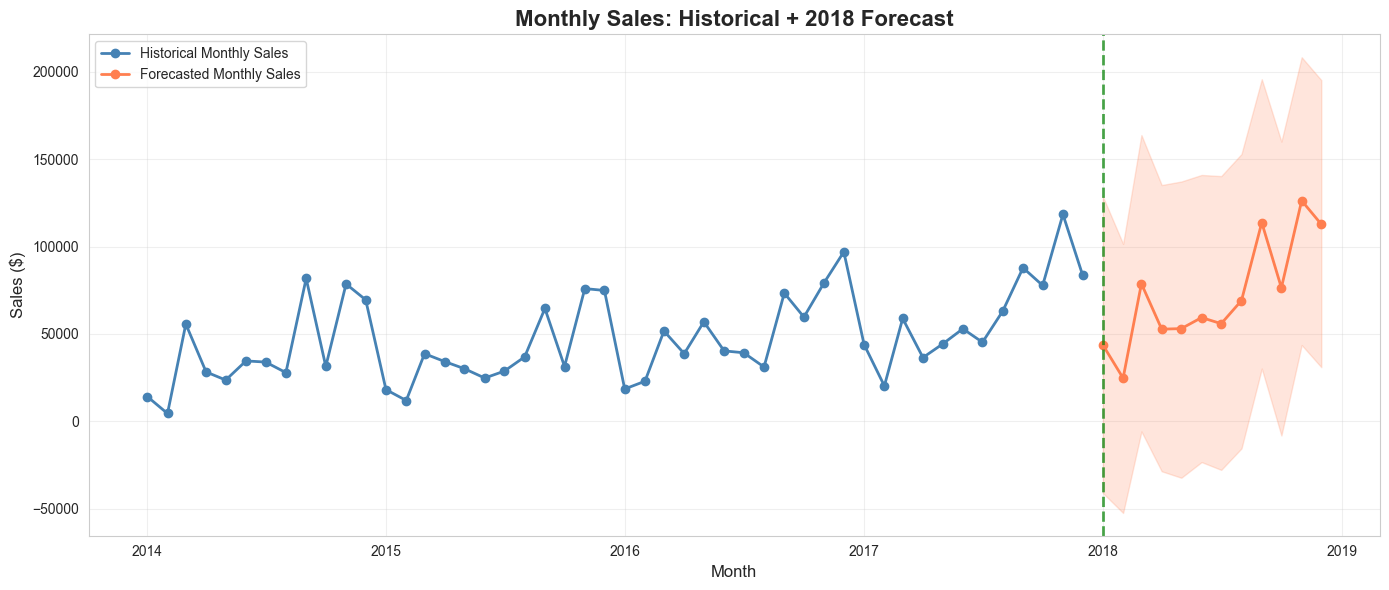


2018 Total Forecast: $866,891.88


In [13]:
# Plot monthly view
fig, ax = plt.subplots(figsize=(14, 6))

# Historical monthly sales
ax.plot(monthly_historical['year_month'], monthly_historical['y'], 
        'o-', color='steelblue', linewidth=2, markersize=6, label='Historical Monthly Sales')

# Forecasted monthly sales
ax.plot(monthly_2018['year_month'], monthly_2018['yhat'], 
        'o-', color='coral', linewidth=2, markersize=6, label='Forecasted Monthly Sales')

# Confidence interval
ax.fill_between(monthly_2018['year_month'], 
                monthly_2018['yhat_lower'], 
                monthly_2018['yhat_upper'],
                color='coral', alpha=0.2)

# Vertical line
ax.axvline(x=pd.Timestamp('2018-01-01'), color='green', 
          linestyle='--', linewidth=2, alpha=0.7)

ax.set_title('Monthly Sales: Historical + 2018 Forecast', fontsize=16, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Sales ($)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n2018 Total Forecast: ${monthly_2018['yhat'].sum():,.2f}")

In [19]:
# Save the monthly forecast for dashboard use
monthly_2018_export = monthly_2018[['year_month', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
monthly_2018_export.columns = ['Month', 'Forecasted_Sales', 'Lower_Bound', 'Upper_Bound']
monthly_2018_export.to_csv('../outputs/processed_data/monthly_forecast_2018.csv', index=False)

# Also save combined historical + forecast
combined = pd.concat([
    monthly_historical[['year_month', 'y']].rename(columns={'y': 'Sales', 'year_month': 'Month'}),
    monthly_2018_export.rename(columns={'Forecasted_Sales': 'Sales'})[['Month', 'Sales']]
])
combined['Type'] = ['Historical'] * len(monthly_historical) + ['Forecast'] * len(monthly_2018_export)
combined.to_csv('../outputs/processed_data/sales_with_forecast.csv', index=False)

print("Forecast data saved!")
print(f"   - monthly_forecast_2018.csv")
print(f"   - sales_with_forecast.csv")

Forecast data saved!
   - monthly_forecast_2018.csv
   - sales_with_forecast.csv


In [18]:
# Create a summary report
summary = {
    'Metric': [
        'Historical Total Sales (2014-2017)',
        'Forecasted Total Sales (2018)',
        'Year-over-Year Growth',
        'Average Monthly Sales (Historical)',
        'Average Monthly Sales (Forecast)',
        'Highest Forecast Month',
        'Lowest Forecast Month',
        'Model MAE (Test Set)',
        'Model RMSE (Test Set)'
    ],
    'Value': [
        f"${daily_sales['y'].sum():,.2f}",
        f"${monthly_2018['yhat'].sum():,.2f}",
        f"{((monthly_2018['yhat'].sum() / 733215.26) - 1) * 100:.1f}%",  # vs 2017
        f"${monthly_historical['y'].mean():,.2f}",
        f"${monthly_2018['yhat'].mean():,.2f}",
        f"November: ${monthly_2018[monthly_2018['yhat'] == monthly_2018['yhat'].max()]['yhat'].values[0]:,.2f}",
        f"February: ${monthly_2018[monthly_2018['yhat'] == monthly_2018['yhat'].min()]['yhat'].values[0]:,.2f}",
        f"${mae:,.2f}",
        f"${rmse:,.2f}"
    ]
}

summary_df = pd.DataFrame(summary)
print("\n" + "="*70)
print("FORECASTING MODEL SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)

# Save summary
summary_df.to_csv('../outputs/processed_data/forecast_summary.csv', index=False)
print("\nSummary saved to forecast_summary.csv")


FORECASTING MODEL SUMMARY
                            Metric                 Value
Historical Total Sales (2014-2017)         $2,297,200.86
     Forecasted Total Sales (2018)           $866,891.88
             Year-over-Year Growth                 18.2%
Average Monthly Sales (Historical)            $47,858.35
  Average Monthly Sales (Forecast)            $72,240.99
            Highest Forecast Month November: $126,282.58
             Lowest Forecast Month  February: $24,740.47
              Model MAE (Test Set)             $2,286.94
             Model RMSE (Test Set)             $3,154.30

Summary saved to forecast_summary.csv


Chart saved to outputs/figures/monthly_sales_forecast.png


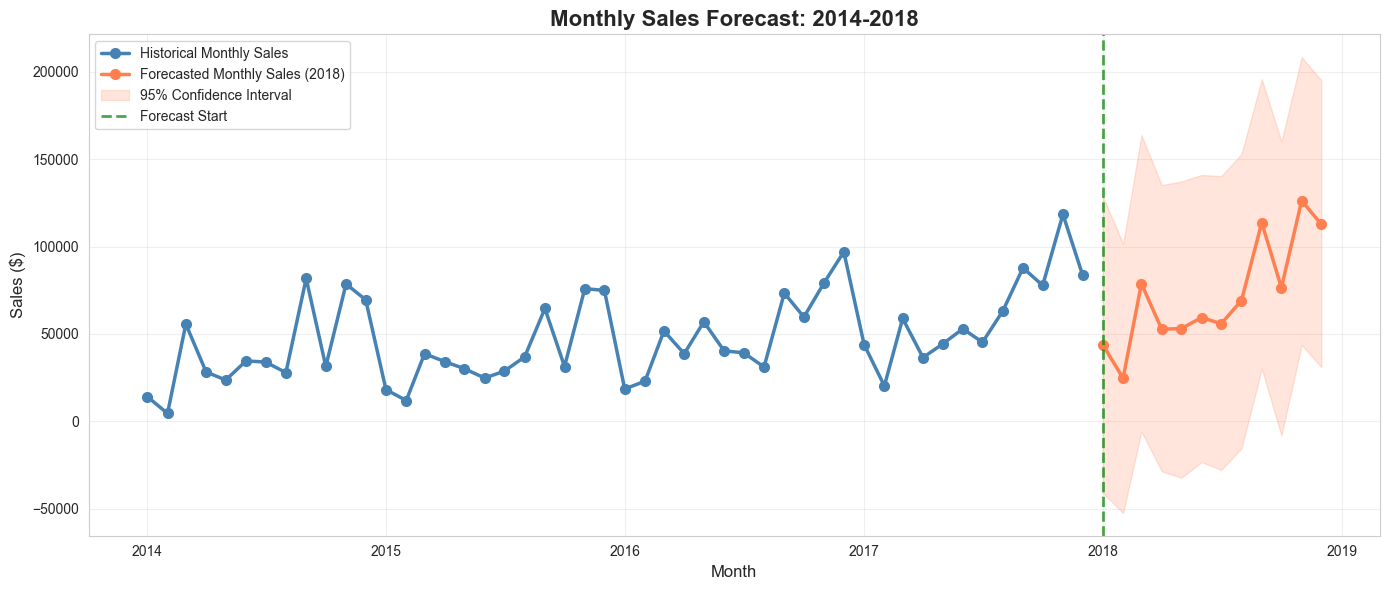

In [17]:
# Save the monthly forecast chart
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(monthly_historical['year_month'], monthly_historical['y'], 
        'o-', color='steelblue', linewidth=2.5, markersize=7, label='Historical Monthly Sales')

ax.plot(monthly_2018['year_month'], monthly_2018['yhat'], 
        'o-', color='coral', linewidth=2.5, markersize=7, label='Forecasted Monthly Sales (2018)')

ax.fill_between(monthly_2018['year_month'], 
                monthly_2018['yhat_lower'], 
                monthly_2018['yhat_upper'],
                color='coral', alpha=0.2, label='95% Confidence Interval')

ax.axvline(x=pd.Timestamp('2018-01-01'), color='green', 
          linestyle='--', linewidth=2, alpha=0.7, label='Forecast Start')

ax.set_title('Monthly Sales Forecast: 2014-2018', fontsize=16, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Sales ($)', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()

# Save figure
plt.savefig('../outputs/figures/monthly_sales_forecast.png', dpi=300, bbox_inches='tight')
print("Chart saved to outputs/figures/monthly_sales_forecast.png")
plt.show()